In [2]:
import pandas as pd
import numpy as np
from functions import fun as f
from itertools import chain
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.externals import joblib
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


#### Import des données

In [3]:
df_all_data = pd.read_csv("data/ATP.csv")

In [4]:
df_all_data.shape

(169690, 49)

#### On se considère comme un parieur sportif ou un bookmaker<br>
Par conséquent, je considère que les informations connues avant le début d'un match<br>
Je vais utiliser seulement, les variables ci-dessoous

In [5]:
# list(df_all_data)

In [6]:
liste_of_feat_used = ['tourney_id', 'tourney_name','surface','draw_size','tourney_level','tourney_date', 'match_num','best_of','round',
'loser_id','loser_seed','loser_entry','loser_name','loser_hand','loser_ht','loser_ioc','loser_age','loser_rank','loser_rank_points',
'winner_id', 'winner_seed','winner_entry','winner_name','winner_hand','winner_ht','winner_ioc','winner_age','winner_rank','winner_rank_points']  

In [7]:
# liste_features_to_keep = []
# liste_features_with_missing = []
for each_col in liste_of_feat_used:
    # On regarde quelles variables ont moins de 5% de valeurs manquantes
    pct_nan_values = (len(df_all_data[df_all_data[each_col].isnull()])/len(df_all_data)*100)  
    print ("feature", each_col,": ", pct_nan_values)

feature tourney_id :  0.0
feature tourney_name :  0.0
feature surface :  1.4962578820201544
feature draw_size :  99.27397018091814
feature tourney_level :  0.0
feature tourney_date :  0.0
feature match_num :  0.0
feature best_of :  0.0
feature round :  0.0
feature loser_id :  0.0
feature loser_seed :  80.63940126112323
feature loser_entry :  85.06747598562083
feature loser_name :  0.0
feature loser_hand :  0.05009134303730332
feature loser_ht :  18.05527727031646
feature loser_ioc :  0.0
feature loser_age :  2.9406564912487476
feature loser_rank :  14.014379162001298
feature loser_rank_points :  45.17944487005716
feature winner_id :  0.0
feature winner_seed :  61.521008898579765
feature winner_entry :  91.30885732806883
feature winner_name :  0.0
feature winner_hand :  0.022983086805350935
feature winner_ht :  11.082562319523838
feature winner_ioc :  0.0
feature winner_age :  1.0377747657493075
feature winner_rank :  11.737285638517296
feature winner_rank_points :  44.43337851376039


On voit qu'il y a beaucoup de valeurs manquantes, plaçons nous après 1991

In [8]:
df_all_data = df_all_data[liste_of_feat_used]

In [9]:
df_all_data['tourney_date_str'] = df_all_data['tourney_date'].map(str)
df_all_data['tourney_year_numeric'] = df_all_data['tourney_date_str'].map(lambda x: int(x[0:4]))

In [10]:
df_all_data_after_1991 = df_all_data[df_all_data['tourney_year_numeric'] >= 1991]

In [11]:
#df_all_data_after_1992 = df_all_data[df_all_data['tourney_year_numeric'] >= 1992]
#df_all_data_after_1992.shape

In [12]:
# On extrait les % de valeurs manquantes par colonne (NaN values)
for each_col in liste_of_feat_used:
    # On regarde quelles variables ont moins de 5% de valeurs manquantes
    pct_nan_values = (len(df_all_data_after_1991[df_all_data_after_1991[each_col].isnull()])/len(df_all_data)*100)  
    print ("feature", each_col,": ", pct_nan_values)

feature tourney_id :  0.0
feature tourney_name :  0.0
feature surface :  0.06953857033413872
feature draw_size :  54.703871766161825
feature tourney_level :  0.0
feature tourney_date :  0.0
feature match_num :  0.0
feature best_of :  0.0
feature round :  0.0
feature loser_id :  0.0
feature loser_seed :  42.70375390417821
feature loser_entry :  43.996110554540635
feature loser_name :  0.0
feature loser_hand :  0.025340326477694623
feature loser_ht :  5.147622134480524
feature loser_ioc :  0.0
feature loser_age :  0.11609405386292651
feature loser_rank :  1.3135718074135188
feature loser_rank_points :  1.8563262419706523
feature winner_id :  0.0
feature winner_seed :  32.61358948671106
feature winner_entry :  48.27744710943485
feature winner_name :  0.0
feature winner_hand :  0.010607578525546585
feature winner_ht :  3.094466379869173
feature winner_ioc :  0.0
feature winner_age :  0.051269962873475156
feature winner_rank :  0.6016854263657258
feature winner_rank_points :  1.149743650185

On enlève les variables ayant des % valeurs manquantes superieurs à 30%,<br>
commme : draw_size, loser_seed,loser_entry, winner_seed,winner_entry<br>
<br>
En effet, on va utiliser un modèle XGBoost qui sait gérer les valeurs manquantes<br>
tant que le taux de valeurs manquantes pour une variable donnée n'est pas trop élevé 

In [13]:
liste_of_feat_used = [each for each in liste_of_feat_used if each not in ['draw_size', 'loser_seed','loser_entry', 'winner_seed','winner_entry']]

In [14]:
liste_of_feat_used.append('tourney_year_numeric')

In [15]:
df_all_data_after_1991 = df_all_data_after_1991[liste_of_feat_used]

In [16]:
df_all_data_after_1991.shape

(92827, 25)

On a maintenant un dataset avec 92827 lignes et 24 variables

Je suis parti du principe que les statistiques des joueurs sont fiables

Principe du modèle de Machine Learning:<br>
étant donné un match entre un joueur 1 = Djokovic et un joueur 2 = Federer<br>
je pense qu'il est important de distinguer :
- la probabilité que le joueur 1, Djokovic gagne sachant que son adversaire est le joueur 2, Federer 
- la probabilité que le joueur 2, Federer gagne sachant que son adversaire est le joueur 1, Dojokovic 

En raison de ce principe, je crée un dataset avec les lignes dupliquées et en inversant l'ordre des joueurs en colonnes

In [17]:
# On se sert de "df_temp" pour créer le dataset de lignes dupliquées
df_temp = df_all_data_after_1991

On crée d'abord la colonne des Y = 1 signifiant que le joueur de "droite" dans le dataframe est le vainqueur<br>
Ajout des Y pour les lignes non dupliquées

In [18]:
liste_var_tourney = ['tourney_id','tourney_name','surface','tourney_level','tourney_date','match_num','best_of','round','tourney_year_numeric']
liste_var_loser = [each for each in list(df_temp) if 'loser' in each]
liste_var_winner = [each for each in list(df_temp) if 'winner' in each]
df_temp = pd.concat([df_temp[liste_var_tourney], df_temp[liste_var_loser], df_temp[liste_var_winner]], axis = 1)

In [19]:
df_temp.shape

(92827, 25)

In [20]:
list(df_temp)

['tourney_id',
 'tourney_name',
 'surface',
 'tourney_level',
 'tourney_date',
 'match_num',
 'best_of',
 'round',
 'tourney_year_numeric',
 'loser_id',
 'loser_name',
 'loser_hand',
 'loser_ht',
 'loser_ioc',
 'loser_age',
 'loser_rank',
 'loser_rank_points',
 'winner_id',
 'winner_name',
 'winner_hand',
 'winner_ht',
 'winner_ioc',
 'winner_age',
 'winner_rank',
 'winner_rank_points']

In [21]:
#del liste_player_opponent
liste_player_opponent = [each.replace("loser","player") for each in list(df_temp)]
liste_player_opponent = [each.replace("winner","opponent") for each in liste_player_opponent]

In [22]:
liste_player_opponent

['tourney_id',
 'tourney_name',
 'surface',
 'tourney_level',
 'tourney_date',
 'match_num',
 'best_of',
 'round',
 'tourney_year_numeric',
 'player_id',
 'player_name',
 'player_hand',
 'player_ht',
 'player_ioc',
 'player_age',
 'player_rank',
 'player_rank_points',
 'opponent_id',
 'opponent_name',
 'opponent_hand',
 'opponent_ht',
 'opponent_ioc',
 'opponent_age',
 'opponent_rank',
 'opponent_rank_points']

In [23]:
df_temp.columns = liste_player_opponent

In [24]:
df_temp.head()

,tourney_id,tourney_name,surface,tourney_level,tourney_date,match_num,best_of,round,tourney_year_numeric,player_id,...,player_rank,player_rank_points,opponent_id,opponent_name,opponent_hand,opponent_ht,opponent_ioc,opponent_age,opponent_rank,opponent_rank_points
76863,1991-301,Auckland,Hard,A,19910107,1,3,R32,1991,101746,...,78.0,459.0,101142,Emilio Sanchez,R,180.0,ESP,25.61,9.0,1487.0
76864,1991-301,Auckland,Hard,A,19910107,2,3,R32,1991,100587,...,220.0,114.0,101613,Malivai Washington,R,180.0,USA,21.55,94.0,371.0
76865,1991-301,Auckland,Hard,A,19910107,3,3,R32,1991,101601,...,212.0,116.0,101179,Jean Philippe Fleurian,R,185.0,FRA,25.32,77.0,468.0
76866,1991-301,Auckland,Hard,A,19910107,4,3,R32,1991,101332,...,72.0,483.0,101117,Eric Jelen,R,180.0,GER,25.83,65.0,502.0
76867,1991-301,Auckland,Hard,A,19910107,5,3,R32,1991,101735,...,28.0,876.0,101901,Chuck Adams,R,185.0,USA,19.71,190.0,142.0


Boucler pour chaque match
Tirer au hasard un nb compris entre 0 et 1
Si ce nb est > 1, garder les colonnes "player" et "opponent" dans le même ordre et créer Y = 1
Sinon, mettre les colonnes "opponent" avant les colonnes "player" et créer Y = 0

In [25]:
# df_temp['Y'] = 1

In [26]:
liste_var_tourney = ['tourney_id','tourney_name','surface','tourney_level','tourney_date','match_num','best_of','round','tourney_year_numeric']
liste_var_player = [each for each in list(df_temp) if 'player' in each]
liste_var_opponent = [each for each in list(df_temp) if 'opponent' in each]

In [27]:
# liste_var_player

In [28]:
list(df_temp)

['tourney_id',
 'tourney_name',
 'surface',
 'tourney_level',
 'tourney_date',
 'match_num',
 'best_of',
 'round',
 'tourney_year_numeric',
 'player_id',
 'player_name',
 'player_hand',
 'player_ht',
 'player_ioc',
 'player_age',
 'player_rank',
 'player_rank_points',
 'opponent_id',
 'opponent_name',
 'opponent_hand',
 'opponent_ht',
 'opponent_ioc',
 'opponent_age',
 'opponent_rank',
 'opponent_rank_points']

In [29]:
# test = df_temp.sample(n=3)

In [30]:
df_temp.head()

,tourney_id,tourney_name,surface,tourney_level,tourney_date,match_num,best_of,round,tourney_year_numeric,player_id,...,player_rank,player_rank_points,opponent_id,opponent_name,opponent_hand,opponent_ht,opponent_ioc,opponent_age,opponent_rank,opponent_rank_points
76863,1991-301,Auckland,Hard,A,19910107,1,3,R32,1991,101746,...,78.0,459.0,101142,Emilio Sanchez,R,180.0,ESP,25.61,9.0,1487.0
76864,1991-301,Auckland,Hard,A,19910107,2,3,R32,1991,100587,...,220.0,114.0,101613,Malivai Washington,R,180.0,USA,21.55,94.0,371.0
76865,1991-301,Auckland,Hard,A,19910107,3,3,R32,1991,101601,...,212.0,116.0,101179,Jean Philippe Fleurian,R,185.0,FRA,25.32,77.0,468.0
76866,1991-301,Auckland,Hard,A,19910107,4,3,R32,1991,101332,...,72.0,483.0,101117,Eric Jelen,R,180.0,GER,25.83,65.0,502.0
76867,1991-301,Auckland,Hard,A,19910107,5,3,R32,1991,101735,...,28.0,876.0,101901,Chuck Adams,R,185.0,USA,19.71,190.0,142.0


In [31]:
# df_temp.dtypes

In [32]:
all_columns = list(df_temp).copy()
all_columns.append("Y")
# all_columns

In [33]:
list(df_temp)

['tourney_id',
 'tourney_name',
 'surface',
 'tourney_level',
 'tourney_date',
 'match_num',
 'best_of',
 'round',
 'tourney_year_numeric',
 'player_id',
 'player_name',
 'player_hand',
 'player_ht',
 'player_ioc',
 'player_age',
 'player_rank',
 'player_rank_points',
 'opponent_id',
 'opponent_name',
 'opponent_hand',
 'opponent_ht',
 'opponent_ioc',
 'opponent_age',
 'opponent_rank',
 'opponent_rank_points']

In [34]:
%%time

# df_toload = pd.DataFrame(columns = all_columns) 
dict_toload = {}

i = 0
for row in df_temp.itertuples():
    # print (row)
    # Tirer au hasard un nb compris entre 0 et 1
    my_number = np.random.uniform()
    #print (my_number)
    dict_toload[i] = []
    if my_number > 0.5:
        # print (i)
        dict_toload[i].append((row.tourney_id,
                          row.tourney_name,
                          row.surface,
                          row.tourney_level,
                          row.tourney_date,
                          row.match_num,
                          row.best_of,
                          row.round,
                          row.tourney_year_numeric,
                          row.player_id,
                          row.player_name,
                          row.player_hand,
                          row.player_ht,
                          row.player_ioc,
                          row.player_age,
                          row.player_rank,
                          row.player_rank_points,
                          row.opponent_id,
                          row.opponent_name,
                          row.opponent_hand,
                          row.opponent_ht,
                          row.opponent_ioc,
                          row.opponent_age,
                          row.opponent_rank,
                          row.opponent_rank_points,
                          1))
    else:
        dict_toload[i].append((row.tourney_id,
                          row.tourney_name,
                          row.surface,
                          row.tourney_level,
                          row.tourney_date,
                          row.match_num,
                          row.best_of,
                          row.round,
                          row.tourney_year_numeric,
                          row.opponent_id,
                          row.opponent_name,
                          row.opponent_hand,
                          row.opponent_ht,
                          row.opponent_ioc,
                          row.opponent_age,
                          row.opponent_rank,
                          row.opponent_rank_points,
                          row.player_id,
                          row.player_name,
                          row.player_hand,
                          row.player_ht,
                          row.player_ioc,
                          row.player_age,
                          row.player_rank,
                          row.player_rank_points,
                          0))
    i = i + 1

CPU times: user 1.46 s, sys: 50.9 ms, total: 1.51 s
Wall time: 1.53 s


In [35]:
df_temp.shape

(92827, 25)

In [36]:
# dict_toload

In [37]:
len(dict_toload)

92827

In [38]:
%%time
dict_toload_modified = {}
for k,v in dict_toload.items():
    dict_toload_modified[k] = list(dict_toload[k][0])

CPU times: user 215 ms, sys: 22.8 ms, total: 238 ms
Wall time: 268 ms


In [39]:
%%time
df_all_data = pd.DataFrame.from_dict(dict_toload_modified, orient='index', columns= all_columns)

CPU times: user 400 ms, sys: 35 ms, total: 435 ms
Wall time: 447 ms


Identifiants de matchs

In [40]:
df_all_data['id_match'] = df_all_data['tourney_id'].astype(str) + "_" + df_all_data['match_num'].astype(str)

In [205]:
# df_all_data = df_temp.copy()

In [41]:
df_all_data.shape

(92827, 27)

In [42]:
df_all_data[["tourney_id","match_num","id_match"]].head()

,tourney_id,match_num,id_match
0,1991-301,1,1991-301_1
1,1991-301,2,1991-301_2
2,1991-301,3,1991-301_3
3,1991-301,4,1991-301_4
4,1991-301,5,1991-301_5


On crée maintenant les features

Recodage de la variable 'round' de manière relative au type de tournoi:
on compte le nombre de tours de manière différente en fonction de si il s'agit
d'un tournoi du Grand Chelem, d'un Master 1000 ou bien d'un tournoi de type ATP Final (Masters de fin de saison)

In [43]:
list(df_all_data)

['tourney_id',
 'tourney_name',
 'surface',
 'tourney_level',
 'tourney_date',
 'match_num',
 'best_of',
 'round',
 'tourney_year_numeric',
 'player_id',
 'player_name',
 'player_hand',
 'player_ht',
 'player_ioc',
 'player_age',
 'player_rank',
 'player_rank_points',
 'opponent_id',
 'opponent_name',
 'opponent_hand',
 'opponent_ht',
 'opponent_ioc',
 'opponent_age',
 'opponent_rank',
 'opponent_rank_points',
 'Y',
 'id_match']

In [209]:
#df_all_data['round'].unique()
#df_all_data.groupby(['tourney_level'])['round'].unique()

In [44]:
df_all_data['round_ordinal'] = df_all_data.apply(f.recode_round_to_ordinal, axis = 1)

In [45]:
del liste_of_feat_used
liste_of_feat_used = list(df_all_data)
liste_var_numeric = list(df_all_data.describe())
liste_var_non_numeric = [each for each in liste_of_feat_used if each not in liste_var_numeric]

On peut :
- on pourrait extraire le pays à partir du nom du tournoi mais ici, on ne le fait pas
- on a besoin de la variable surface = priorité
- on a besoin de la variable tourney_level = priorité
- on auarait besoin de loser_ioc et winner_ioc pour savoir si un joueur joue dans son pays ou pas

In [46]:
liste_var_non_numeric

['tourney_id',
 'tourney_name',
 'surface',
 'tourney_level',
 'round',
 'player_name',
 'player_hand',
 'player_ioc',
 'opponent_name',
 'opponent_hand',
 'opponent_ioc',
 'id_match']

In [213]:
# Création du pays du tournoi<br>
# Ensuite toutes les variables pourront être transformées avec "labels encoding" de Scikit-learn

In [214]:
# Pays du tournoi

In [215]:
# df_all_data_with_duplicates['tourney_name'].value_counts()

Application de "labels encoding" aux variables : surface et tourney_level

In [47]:
df_all_data['surface'] = df_all_data['surface'].astype(str)
df_all_data['player_hand'] = df_all_data['player_hand'].astype(str)
df_all_data['opponent_hand'] = df_all_data['opponent_hand'].astype(str)

In [48]:
for each in ['surface','tourney_level','player_hand','opponent_hand']:
    #print (each)
    df_all_data = f.to_le(df_all_data,each)

In [49]:
df_all_data.head()

,tourney_id,tourney_name,surface,tourney_level,tourney_date,match_num,best_of,round,tourney_year_numeric,player_id,...,opponent_age,opponent_rank,opponent_rank_points,Y,id_match,round_ordinal,surface_labels_encoding,tourney_level_labels_encoding,player_hand_labels_encoding,opponent_hand_labels_encoding
0,1991-301,Auckland,Hard,A,19910107,1,3,R32,1991,101746,...,25.61,9.0,1487.0,1,1991-301_1,4,3,0,1,1
1,1991-301,Auckland,Hard,A,19910107,2,3,R32,1991,101613,...,31.82,220.0,114.0,0,1991-301_2,4,3,0,1,1
2,1991-301,Auckland,Hard,A,19910107,3,3,R32,1991,101179,...,21.70,212.0,116.0,0,1991-301_3,4,3,0,1,1
3,1991-301,Auckland,Hard,A,19910107,4,3,R32,1991,101117,...,23.85,72.0,483.0,0,1991-301_4,4,3,0,1,0
4,1991-301,Auckland,Hard,A,19910107,5,3,R32,1991,101735,...,19.71,190.0,142.0,1,1991-301_5,4,3,0,1,1


On s'occupe maintenant de la création des features numériques

In [50]:
liste_var_numeric

['tourney_date',
 'match_num',
 'best_of',
 'tourney_year_numeric',
 'player_id',
 'player_ht',
 'player_age',
 'player_rank',
 'player_rank_points',
 'opponent_id',
 'opponent_ht',
 'opponent_age',
 'opponent_rank',
 'opponent_rank_points',
 'Y',
 'round_ordinal']

On va utiliser en priorité les variables : "player_" et "opponent_" comme features numériques

In [51]:
liste_var_player = [each for each in liste_var_numeric if 'player' in each and each != 'player_id']
liste_var_opponent = [each for each in liste_var_numeric if 'opponent' in each and each != 'opponent_id']

In [104]:
# liste_feat_le_for_xgboost = [each for each in list(df_all_data_with_duplicates) if 'labels_encoding' in each or 'ordinal' in each]
liste_feat_le_for_xgboost = [each for each in list(df_all_data) if 'labels_encoding' in each]

In [105]:
liste_feat_le_for_xgboost

['surface_labels_encoding',
 'tourney_level_labels_encoding',
 'player_hand_labels_encoding',
 'opponent_hand_labels_encoding']

In [106]:
init = []
init.append(liste_feat_le_for_xgboost)
init.append(liste_var_player)
init.append(liste_var_opponent)

liste_feat_for_xgboost_modele_1 = list(chain(*init))

In [107]:
liste_feat_for_xgboost_modele_1

['surface_labels_encoding',
 'tourney_level_labels_encoding',
 'player_hand_labels_encoding',
 'opponent_hand_labels_encoding',
 'player_ht',
 'player_age',
 'player_rank',
 'player_rank_points',
 'opponent_ht',
 'opponent_age',
 'opponent_rank',
 'opponent_rank_points']

#### On réalise Holdout : on va créer 
- un train set =  60 % 
- validation set = , 20 % 
- test set = 20 %

In [56]:
df_all_data[['id_match','player_name','opponent_name']].sort_values(by=['id_match']).head()

,id_match,player_name,opponent_name
268,1991-201_1,Rodolphe Gilbert,Luiz Mattar
277,1991-201_10,Gianluca Pozzi,Henrik Holm
278,1991-201_11,Martin Wostenholme,Lawson Duncan
279,1991-201_12,Horacio De La Pena,Pablo Albano
280,1991-201_13,Tarik Benhabiles,Marcelo Saliola


In [57]:
id_match_unique = df_all_data['id_match'].unique()

In [58]:
# Shuffle du numpy array
np.random.shuffle(id_match_unique)

In [59]:
# 60%, 20% et 20%
idx_1 = int(0.6*len(id_match_unique))
idx_2 = int(0.8*len(id_match_unique))
id_train = id_match_unique[:idx_1]
id_valid = id_match_unique[idx_1+1:idx_2]
id_test = id_match_unique[idx_2+1:]

In [60]:
df_all_data.shape

(92827, 32)

In [61]:
X_train_all_columns = df_all_data[df_all_data['id_match'].isin(id_train)]
Y_train = df_all_data[["id_match","Y"]][df_all_data[["id_match","Y"]]['id_match'].isin(id_train)][["Y"]]

In [62]:
X_train_all_columns[['id_match']].head()

,id_match
0,1991-301_1
1,1991-301_2
2,1991-301_3
3,1991-301_4
4,1991-301_5


In [63]:
X_train_all_columns.shape

(55696, 32)

In [64]:
Y_train.sample(n=10)

,Y
70780,0
30290,1
23249,1
15422,1
23293,0
40717,1
91275,1
82849,1
92240,1
45041,1


In [234]:
# (X_train_all_columns.shape[0]/df_all_data.shape[0])*100

In [65]:
X_valid_all_columns = df_all_data[df_all_data['id_match'].isin(id_valid)]
Y_valid = df_all_data[["id_match","Y"]][df_all_data[["id_match","Y"]]['id_match'].isin(id_valid)][["Y"]]
X_test_all_columns =  df_all_data[df_all_data['id_match'].isin(id_test)]
Y_test = df_all_data[["id_match","Y"]][df_all_data[["id_match","Y"]]['id_match'].isin(id_test)]

In [236]:
# (X_valid_all_columns.shape[0]/df_all_data_with_duplicates.shape[0])*100

In [237]:
# X_test_all_columns.shape

In [238]:
# Y_valid.shape

In [239]:
# X_test_all_columns.shape

In [240]:
# (X_test_all_columns.shape[0]/df_all_data_with_duplicates.shape[0])*100

In [241]:
#Y_test.shape

In [66]:
X_train = X_train_all_columns[liste_feat_for_xgboost_modele_1]
X_valid = X_valid_all_columns[liste_feat_for_xgboost_modele_1]

On crée un XGBoost accompagné d'un tuning des hyperparamètres

In [67]:
X_train.shape

(55696, 12)

In [68]:
X_train.head()

,surface_labels_encoding,tourney_level_labels_encoding,player_hand_labels_encoding,opponent_hand_labels_encoding,player_ht,player_age,player_rank,player_rank_points,opponent_ht,opponent_age,opponent_rank,opponent_rank_points
0,3,0,1,1,175.0,20.64,78.0,459.0,180.0,25.61,9.0,1487.0
1,3,0,1,1,180.0,21.55,94.0,371.0,188.0,31.82,220.0,114.0
2,3,0,1,1,185.0,25.32,77.0,468.0,185.0,21.70,212.0,116.0
3,3,0,1,0,180.0,25.83,65.0,502.0,173.0,23.85,72.0,483.0
4,3,0,1,1,196.0,20.70,28.0,876.0,185.0,19.71,190.0,142.0


In [69]:
liste_feat_for_xgboost_modele_1

['surface_labels_encoding',
 'tourney_level_labels_encoding',
 'player_hand_labels_encoding',
 'opponent_hand_labels_encoding',
 'player_ht',
 'player_age',
 'player_rank',
 'player_rank_points',
 'opponent_ht',
 'opponent_age',
 'opponent_rank',
 'opponent_rank_points']

In [70]:
Y_train.shape

(55696, 1)

In [73]:
%%time
# n_iter = 100
n_iter = 2
df_result_models = pd.DataFrame(columns = ['colsample_bytree','learning_rate','max_depth','n_estimators','subsample','min_child_weight','reg_lambda','AUC_train','AUC_valid'])

for each in range(1,n_iter):
    
    colsample_bytree_value = np.random.uniform(0.3,0.7)
    learning_rate_value = np.random.uniform(0.03, 0.3)
    max_depth_value = np.random.randint(7,20)
    # max_depth_value = np.random.randint(5,12)
    n_estimators_value = np.random.randint(400, 500)
    # n_estimators_value = np.random.randint(100, 200)
    # subsample_value = np.random.uniform(0.4, 0.6)
    subsample_value = 1
    reg_lambda_value = np.random.uniform(5, 20)
    min_child_weight_value = np.random.randint(0,300)
    
    xgb_model = xgb.XGBClassifier(
        colsample_bytree = colsample_bytree_value,
        learning_rate = learning_rate_value,
        max_depth = max_depth_value,
        n_estimators = n_estimators_value,
        subsample = subsample_value,
        reg_lambda = reg_lambda_value,
        n_jobs = 2,
        min_child_weight = min_child_weight_value,
        objective='binary:logistic')
        
    result = xgb_model.fit(X_train, Y_train.values.ravel())
    predicted_values = xgb_model.predict_proba(X_train)[:,1]
    predicted_values = np.expand_dims(predicted_values, axis=1)
    
    AUC_train_value = roc_auc_score(Y_train.values, predicted_values)
    
    predicted_values = xgb_model.predict_proba(X_valid)[:,1]
    predicted_values = np.expand_dims(predicted_values, axis=1)
        
    AUC_valid_value = roc_auc_score(Y_valid.values, predicted_values)
    
    if AUC_train_value != None and AUC_valid_value != None:
    
        df_result_models = df_result_models.append({'colsample_bytree': colsample_bytree_value, 
                                 'learning_rate':learning_rate_value,
                                 'max_depth':max_depth_value,
                                 'n_estimators':n_estimators_value,
                                 'subsample':subsample_value,
                                 'reg_lambda':reg_lambda_value,
                                 'min_child_weight':min_child_weight_value,                 
                                 'AUC_train':AUC_train_value,
                                 'AUC_valid':AUC_valid_value}, ignore_index= True)

CPU times: user 44.3 s, sys: 496 ms, total: 44.8 s
Wall time: 22.9 s


In [75]:
# stockage en .pkl
joblib.dump(xgb_model, "xgboost_modele_1_without_win_margin.pkl", compress=9)
# pour le reload
xgb_model = joblib.load("xgboost_modele_1_without_win_margin.pkl")

In [76]:
predicted_values = xgb_model.predict_proba(X_train)[:,1]
predicted_values = np.expand_dims(predicted_values, axis=1)
predicted_values.shape

(55696, 1)

In [253]:
df_result_models

,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,min_child_weight,reg_lambda,AUC_train,AUC_valid
0,0.402319,0.22827,7.0,477.0,1.0,294.0,5.124797,0.765798,0.717142


##### Avec subsample = 1 : j'avais ce résultat :

In [515]:
df_result_models

,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,min_child_weight,reg_lambda,AUC_train,AUC_valid
0,0.400109,0.032849,18.0,469.0,1.0,69.0,13.445332,0.787675,0.72605


Avec 'round_ordinal' : PAS TESTE<br>
Cela semble donner du sur-apprentissage:<br>
On pourrait faire varier successivement chaque hyperparamètre en gardant les autres hyperparamètres fixé

Importance des variables: AVANT:

In [66]:
dict_feature_importance = {}
for each in list(zip(list(X_train),xgb_model.feature_importances_)):
    dict_feature_importance[each[0]] = each[1]
sorted_importances = sorted(dict_feature_importance.items() , reverse = True, key=lambda x: x[1])
for elem in sorted_importances :
    print(elem[0] , " ::" , elem[1])

player_rank  :: 0.17257395
opponent_rank_points  :: 0.12709759
opponent_rank  :: 0.119993925
player_rank_points  :: 0.088540286
player_hand_labels_encoding  :: 0.085398465
tourney_level_labels_encoding  :: 0.08162489
opponent_hand_labels_encoding  :: 0.07802199
player_ht  :: 0.076015785
opponent_ht  :: 0.055617627
surface_labels_encoding  :: 0.03886766
player_age  :: 0.03855893
opponent_age  :: 0.03768892


In [254]:
dict_feature_importance = {}
for each in list(zip(list(X_train),xgb_model.feature_importances_)):
    dict_feature_importance[each[0]] = each[1]
sorted_importances = sorted(dict_feature_importance.items() , reverse = True, key=lambda x: x[1])
for elem in sorted_importances :
    print(elem[0] , " ::" , elem[1])

player_rank  :: 0.21202485
opponent_rank  :: 0.16643013
opponent_rank_points  :: 0.13429113
player_rank_points  :: 0.10057502
player_ht  :: 0.083280616
tourney_level_labels_encoding  :: 0.076903276
opponent_ht  :: 0.062523544
player_age  :: 0.039800752
opponent_age  :: 0.03814017
surface_labels_encoding  :: 0.032589827
player_hand_labels_encoding  :: 0.031197162
opponent_hand_labels_encoding  :: 0.022243459


Ci-dessous, on calcule la prédiction pour un match donné dans le test set (3ème échantillon)

In [255]:
liste_feat_for_xgboost_modele_1

['surface_labels_encoding',
 'tourney_level_labels_encoding',
 'player_hand_labels_encoding',
 'opponent_hand_labels_encoding',
 'player_ht',
 'player_age',
 'player_rank',
 'player_rank_points',
 'opponent_ht',
 'opponent_age',
 'opponent_rank',
 'opponent_rank_points']

#### Hypothèse des gains en cas de bonne ou mauvaise prédiction:
- on gagne la valeur de la mise en cas de bonne prédiction
- on perd la valeur de la mise en cas de mauvaise prédiction

Code pour créer la fonction: <br>
- input : dataframe df_all_data_with_duplicates et numpy array : id_train ou id_valid ou id_test
- output: dataframe df_pred contenant pour chaque match la winning margin, les prédictions et les Y vérité

In [256]:
list(df_all_data)

['tourney_id',
 'tourney_name',
 'surface',
 'tourney_level',
 'tourney_date',
 'match_num',
 'best_of',
 'round',
 'tourney_year_numeric',
 'player_id',
 'player_name',
 'player_hand',
 'player_ht',
 'player_ioc',
 'player_age',
 'player_rank',
 'player_rank_points',
 'opponent_id',
 'opponent_name',
 'opponent_hand',
 'opponent_ht',
 'opponent_ioc',
 'opponent_age',
 'opponent_rank',
 'opponent_rank_points',
 'Y',
 'id_match',
 'round_ordinal',
 'surface_labels_encoding',
 'tourney_level_labels_encoding',
 'player_hand_labels_encoding',
 'opponent_hand_labels_encoding']

A faire en cas de pb avec "liste_feat_for_xgboost_modele_1"

In [175]:
# liste_feat_le_for_xgboost = [each for each in list(df_all_data_with_duplicates) if 'labels_encoding' in each]
# init = []
# init.append(liste_feat_le_for_xgboost)
# init.append(liste_var_player)
# init.append(liste_var_opponent)
# liste_feat_for_xgboost_modele_1 = list(chain(*init))

In [172]:
# liste_feat_for_xgboost_modele_1

Calcul :
- de la winning margin avec : un groupby "id_match", abs(pred_0 - pred_1)<br>
- de la prédiction de chaque match avec : un groupby "id_match", max(pred_0, pred_1)

In [258]:
id_obs = id_train.copy()
df = df_all_data.copy()
which_dataset = "train"

X_all_columns = df[df['id_match'].isin(id_obs)]

liste_columns =  liste_feat_for_xgboost_modele_1.copy()
liste_columns.append("id_match")
df_temp = X_all_columns[liste_columns]
del liste_columns

Y = df[["id_match","Y"]][df[["id_match","Y"]]['id_match'].isin(id_obs)]

df_temp = df_temp.sort_values(by = "id_match")
Y = Y.sort_values(by = "id_match")

df_temp_for_prediction = df_temp[[each for each in list(df_temp) if each != "id_match"]]

predicted_values = xgb_model.predict_proba(df_temp_for_prediction)[:,1]
predicted_values = np.expand_dims(predicted_values, axis=1)
Y_without_id_match = Y.drop("id_match", axis = 1)

AUC_value = roc_auc_score(Y_without_id_match.values, predicted_values)
# print ("AUC sur le train set: ", AUC_train_value)
print ("AUC sur le ", which_dataset,  " set: ", AUC_value)

df_predicted_values = pd.DataFrame({'id_match':df_temp["id_match"].values, 'pred': predicted_values[:, 0]})

# df_predicted_values.shape
# df_predicted_values.head()

Y.reset_index(drop = False, inplace = True)
df_predicted_values.reset_index(drop = False, inplace = True)

df_predicted_values["Y"] = Y["Y"]
df_predicted_values.head()

df_temp_names_players = X_all_columns[["id_match","player_name","opponent_name"]]
df_temp_names_players = df_temp_names_players.sort_values(by = "id_match")

df_temp_names_players.reset_index(drop = False, inplace = True)
df_predicted_values.reset_index(drop = False, inplace = True)
df_predicted_values["player_name"] = df_temp_names_players["player_name"]
df_predicted_values["opponent_name"] = df_temp_names_players["opponent_name"]

df_predicted_values = df_predicted_values.drop(["level_0","index"], axis = 1)

AUC sur le  train  set:  0.7657982276880064


In [259]:
df_predicted_values.head()

,id_match,pred,Y,player_name,opponent_name
0,1991-201_10,0.513388,0,Henrik Holm,Gianluca Pozzi
1,1991-201_13,0.366543,0,Tarik Benhabiles,Marcelo Saliola
2,1991-201_14,0.506069,1,Christer Allgardh,Chris Garner
3,1991-201_15,0.624339,0,Fernando Roese,Johan Carlsson
4,1991-201_16,0.427359,1,Marcelo Filippini,Danilo Marcelino


In [77]:
# which_dataset = "train" ou "valid" ou "test"
def fun_pred_truth(df,id_obs,which_dataset):
    
    X_all_columns = df[df['id_match'].isin(id_obs)]
    
    liste_columns =  liste_feat_for_xgboost_modele_1.copy()
    liste_columns.append("id_match")
    df_temp = X_all_columns[liste_columns]
    del liste_columns

    Y = df[["id_match","Y"]][df[["id_match","Y"]]['id_match'].isin(id_obs)]

    df_temp = df_temp.sort_values(by = "id_match")
    Y = Y.sort_values(by = "id_match")

    df_temp_for_prediction = df_temp[[each for each in list(df_temp) if each != "id_match"]]

    predicted_values = xgb_model.predict_proba(df_temp_for_prediction)[:,1]
    predicted_values = np.expand_dims(predicted_values, axis=1)
    Y_without_id_match = Y.drop("id_match", axis = 1)

    AUC_value = roc_auc_score(Y_without_id_match.values, predicted_values)
    # print ("AUC sur le train set: ", AUC_train_value)
    print ("AUC sur le ", which_dataset,  " set: ", AUC_value)
    
    df_predicted_values = pd.DataFrame({'id_match':df_temp["id_match"].values, 'pred': predicted_values[:, 0]})

    # df_predicted_values.shape
    # df_predicted_values.head()

    Y.reset_index(drop = False, inplace = True)
    df_predicted_values.reset_index(drop = False, inplace = True)

    df_predicted_values["Y"] = Y["Y"]
    df_predicted_values.head()

    df_temp_names_players = X_all_columns[["id_match","player_name","opponent_name"]]
    df_temp_names_players = df_temp_names_players.sort_values(by = "id_match")

    df_temp_names_players.reset_index(drop = False, inplace = True)
    df_predicted_values.reset_index(drop = False, inplace = True)
    df_predicted_values["player_name"] = df_temp_names_players["player_name"]
    df_predicted_values["opponent_name"] = df_temp_names_players["opponent_name"]
    df_predicted_values = df_predicted_values.drop(["level_0","index"], axis = 1)

    return df_predicted_values

In [78]:
df_pred_train = fun_pred_truth(df_all_data,id_train,"train")
df_pred_valid = fun_pred_truth(df_all_data,id_valid,"valid")
df_pred_test = fun_pred_truth(df_all_data,id_test,"test")

AUC sur le  train  set:  0.7931318898872856
AUC sur le  valid  set:  0.7165367794751074
AUC sur le  test  set:  0.7149285752888216


In [179]:
# df_predicted_values_train[((df_predicted_values_train["opponent_name"] == 'Roger Federer') & \
#                          (df_predicted_values_train["player_name"] == 'Robin Soderling') & \
#                          (df_predicted_values_train["year"] == '2009')) | \
#                         ((df_predicted_values_train["opponent_name"] == 'Robin Soderling') & \
#                          (df_predicted_values_train["player_name"] == 'Roger Federer') & \
#                          (df_predicted_values_train["year"] == '2009'))]

NB) Le vainqueur de chaque match est le joueur "opponent" si Y = 1<br>
sinon c'est le joueur "player"

In [79]:
df_pred_train.sample(n=3)

,id_match,pred,Y,player_name,opponent_name
41358,2011-315_1,0.330362,0,John Isner,Karol Beck
44295,2012-560_51,0.483522,1,Lukasz Kubot,Leonardo Mayer
51024,2016-560_156,0.433573,0,Feliciano Lopez,Borna Coric


In [80]:
def gain_for_each_match(df):
    if df['Y'] == df['Y_pred']:
        gain = +1 
    else:
        gain = -1 
    return gain

Si on considère une seule proba prédite<br>
On peut en déduire la Precision P<br>
Pour le Recall R, il faut calculer le nombre de faux négatifs<br>
Nombre de faux négatifs = nombre de vainqueurs des matchs qui n'ont pas été prédits comme vainqueurs

Ici: la proba prédite est pred_max

- Une Precision élevée est équivalente à un taux faible de faux positifs 
- Un Recall élevé est équivalent à un taux faible de faux négatifs

Sachant que :
- Precision = nombre de bonnes prédictions / (nombre de prédictions bonnes + nombre de mauvaises prédictions)
            = nombre de vrais positifs / (nombre de vrais positifs + nombre de faux positifs)
    $P = \frac{T_p}{T_p+F_p}$
- Recall = nombre de vrais positifs / (nombre de vrais positifs + nombre de faux négatifs)
    $R = \frac{T_p}{T_p + F_n}$

- F1-score:
    $F1 = 2\frac{P \times R}{P+R}$

Ou bien on peut calculer avec Scikit-learn

In [81]:
df_pred_train.head()

,id_match,pred,Y,player_name,opponent_name
0,1991-201_1,0.727929,0,Rodolphe Gilbert,Luiz Mattar
1,1991-201_10,0.527984,1,Gianluca Pozzi,Henrik Holm
2,1991-201_12,0.441160,1,Horacio De La Pena,Pablo Albano
3,1991-201_14,0.459194,0,Chris Garner,Christer Allgardh
4,1991-201_19,0.596452,1,Gabriel Markus,Patrick Baur


In [82]:
precision, recall, thresholds = precision_recall_curve(df_pred_train[["Y"]], df_pred_train[["pred"]])
f1 = 2*((precision*recall)/(precision+recall))

thresh_proba = thresholds[np.where(f1 == max(f1))][0]
print (thresh_proba)
df_pred_train['Y_pred'] = df_pred_train['pred'].map(lambda x: 1 if x > thresh_proba else 0)
df_pred_train['gain'] = df_pred_train.apply(gain_for_each_match, axis = 1)

0.40419278


In [83]:
df_pred_train.sample(n=10)

,id_match,pred,Y,player_name,opponent_name,Y_pred,gain
32280,2006-375_17,0.568305,1,Michael Llodra,Arnaud Clement,1,1
8639,1994-540_24,0.120793,0,Marc Rosset,David Witt,0,1
37402,2008-D035_2,0.069362,0,Stanislas Wawrinka,Uladzimir Ignatik,0,1
36803,2008-520_118,0.169776,0,Novak Djokovic,Paul Henri Mathieu,0,1
33487,2006-773_24,0.295407,0,Florent Serra,Martin Vassallo Arguello,0,1
15231,1997-520_75,0.889531,1,Salvador Navarro,Jan Siemerink,1,1
30600,2005-418_15,0.879207,1,Alex Clayton,Bobby Reynolds,1,1
34453,2007-410_43,0.776603,1,Igor Andreev,Juan Carlos Ferrero,1,1
22747,2001-416_7,0.556694,0,Tommy Haas,Andrei Medvedev,1,-1
14513,1997-408_20,0.349056,1,Mark Philippoussis,David Prinosil,0,-1


In [84]:
# j'ai gagné 40 % de ma mise
sampled = df_pred_train.sample(n=10)
(sampled.gain.sum()/len(sampled))*100

60.0

In [85]:
print ("% de bonnes prédictions: ", round((df_pred_train[df_pred_train.gain == 1].shape[0]/df_pred_train.shape[0])*100))

% de bonnes prédictions:  69


In [86]:
def plot_f1_with_probas(df,type_dataset):
    precision, recall, thresholds = precision_recall_curve(df[["Y"]], df[["pred"]])
    f1 = 2*((precision*recall)/(precision+recall))
    
    liste_thresh = []
    liste_thresh.append(0)
    for each in list(thresholds):
        liste_thresh.append(each)
        
    resultat = plt.plot(liste_thresh,list(f1), label = "F1-score on " + type_dataset)
    del liste_thresh
    return resultat

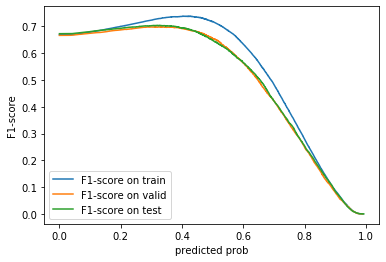

In [87]:
plot_f1_with_probas(df_pred_train,"train")
plot_f1_with_probas(df_pred_valid,"valid")
plot_f1_with_probas(df_pred_test,"test")
plt.xlabel('predicted prob')
plt.ylabel('F1-score')
leg = plt.legend()

On suppose qu'on mise 1 euro par match

In [88]:
def compute_gain(df):
    resultat = []
    precision, recall, thresholds = precision_recall_curve(df[["Y"]], df[["pred"]])
    f1 = 2*((precision*recall)/(precision+recall))

    # On définit le seuil de probabilité : c'est la proba telle que le F1-score soit maximum
    thresh_proba = thresholds[np.where(f1 == max(f1))][0]
    
    print ("THRESHOLD PROBA with MAX F1 :", thresh_proba)

    df['Y_pred'] = df['pred'].map(lambda x: 1 if x > thresh_proba else 0)
    df['gain'] = df.apply(gain_for_each_match, axis = 1)
    
    # % des victoires prédites correctement
    # Et % des gains obtenus en misant 1 euro pour chaque match
    resultat.append(round((len(df[df.gain == 1])/len(df))*100))
    resultat.append(round((df.gain.sum()/len(df))*100))

    return resultat

In [89]:
compute_gain(df_pred_train)

THRESHOLD PROBA with MAX F1 : 0.40419278


[69, 39.0]

In [90]:
compute_gain(df_pred_valid)

THRESHOLD PROBA with MAX F1 : 0.29183012


[60, 20.0]

In [91]:
compute_gain(df_pred_test)

THRESHOLD PROBA with MAX F1 : 0.3253111


[62, 24.0]

### Evaluation du modèle sur le test set

In [108]:
liste_columns_test =  liste_feat_for_xgboost_modele_1
liste_columns_test.append("id_match")

In [124]:
df_temp = X_test_all_columns[liste_columns_test]

In [125]:
df_temp = df_temp.sort_values(by = "id_match")
Y_test = Y_test.sort_values(by = "id_match")

In [126]:
df_temp_for_prediction = df_temp[[each for each in list(df_temp)]]

df_pred_test a CREER en .pkl avec le nom : "df_pred_test_built_without_win_margin"

In [127]:
df_temp_for_prediction.to_pickle('df_pred_test_built_without_win_margin.pkl')
Y_test_without_id_match = Y_test.drop("id_match", axis = 1)
Y_test_without_id_match.to_pickle('Y_test_built_without_win_margin.pkl')

In [77]:
df_temp_for_prediction = df_temp_for_prediction[[each for each in list(df_temp_for_prediction) if each != "id_match"]]
predicted_values_test = xgb_model.predict_proba(df_temp_for_prediction)[:,1]
predicted_values_test = np.expand_dims(predicted_values_test, axis=1)
# Y_test_without_id_match = Y_test.drop("id_match", axis = 1)

In [78]:
AUC_test_value = roc_auc_score(Y_test_without_id_match.values, predicted_values_test)
print ("AUC sur le test set: ", AUC_test_value)

df_predicted_values_test = pd.DataFrame({'id_match':df_temp["id_match"].values, 'pred': predicted_values_test[:, 0]})

AUC sur le test set:  0.7150225545246902


In [79]:
df_predicted_values_test.shape

(37130, 2)

In [80]:
df_predicted_values_test.head()

,id_match,pred
0,1991-201_1,0.266469
1,1991-201_1,0.735270
2,1991-201_31,0.524624
3,1991-201_31,0.472638
4,1991-215_12,0.678846


In [764]:
Y_test.reset_index(drop = False, inplace = True)
df_predicted_values_test.reset_index(drop = False, inplace = True)

In [765]:
df_predicted_values_test["Y"] = Y_test["Y"]

In [766]:
df_predicted_values_test.head()

,index,id_match,pred,Y
0,0,1991-201_10,0.487031,0
1,1,1991-201_10,0.546485,1
2,2,1991-201_15,0.465190,1
3,3,1991-201_15,0.560148,0
4,4,1991-201_22,0.449912,0


In [767]:
df_temp_names_players = X_test_all_columns[["id_match","player_name","opponent_name"]]

In [768]:
df_temp_names_players = df_temp_names_players.sort_values(by = "id_match")

In [769]:
df_temp_names_players.reset_index(drop = False, inplace = True)
df_predicted_values_test.reset_index(drop = False, inplace = True)
df_predicted_values_test["player_name"] = df_temp_names_players["player_name"]
df_predicted_values_test["opponent_name"] = df_temp_names_players["opponent_name"]

In [775]:
df_predicted_values_test = df_predicted_values_test.drop(["level_0","index"], axis = 1)
df_predicted_values_test.head(n=20)

,id_match,pred,Y,player_name,opponent_name
0,1991-201_10,0.487031,0,Henrik Holm,Gianluca Pozzi
1,1991-201_10,0.546485,1,Gianluca Pozzi,Henrik Holm
2,1991-201_15,0.465190,1,Johan Carlsson,Fernando Roese
3,1991-201_15,0.560148,0,Fernando Roese,Johan Carlsson
4,1991-201_22,0.449912,0,Martin Wostenholme,Pablo Albano
5,1991-201_22,0.574797,1,Pablo Albano,Martin Wostenholme
6,1991-201_28,0.482237,1,Chris Garner,Fernando Roese
7,1991-201_28,0.514887,0,Fernando Roese,Chris Garner
8,1991-201_3,0.565606,1,Jose Francisco Altur,Shuzo Matsuoka
9,1991-201_3,0.440273,0,Shuzo Matsuoka,Jose Francisco Altur


#### Il reste ici à associer des définir des gains en cas de bonnes prédictions ou de mauvaises prédictions